# My Own pbmc3k

## Installation of data

In [1]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

--2020-05-25 15:12:11--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving in (in)... 10.20.0.50
Connecting to in (in)|10.20.0.50|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

100%[======================================>] 7,621,991   5.11MB/s   in 1.4s   

2020-05-25 15:12:13 (5.11 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’ saved [7621991/7621991]



## Import of packages

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

## Scanpy settings

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.5.1 anndata==0.7.3 umap==0.4.3 numpy==1.17.5 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.23.1 statsmodels==0.11.1


/home/julienlin/miniconda3/envs/singleCel/lib/python3.7/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


## Notebook settings

In [ ]:
!mkdir -p write

In [4]:
results_file = './write/pbmc3k.h5ad'  # the file that will store the analysis results

In [5]:
adata=sc.read_10x_mtx('./data/filtered_gene_bc_matrices/hg19',var_names='gene_symbols',
                      cache=True, cache_compression='gzip')

... writing an h5ad cache file to speedup reading next time


In [6]:
adata.var_names_make_unique()

In [7]:
adata.shape

(2700, 32738)

## Preprocessing

normalizing counts per cell
    finished (0:00:00)


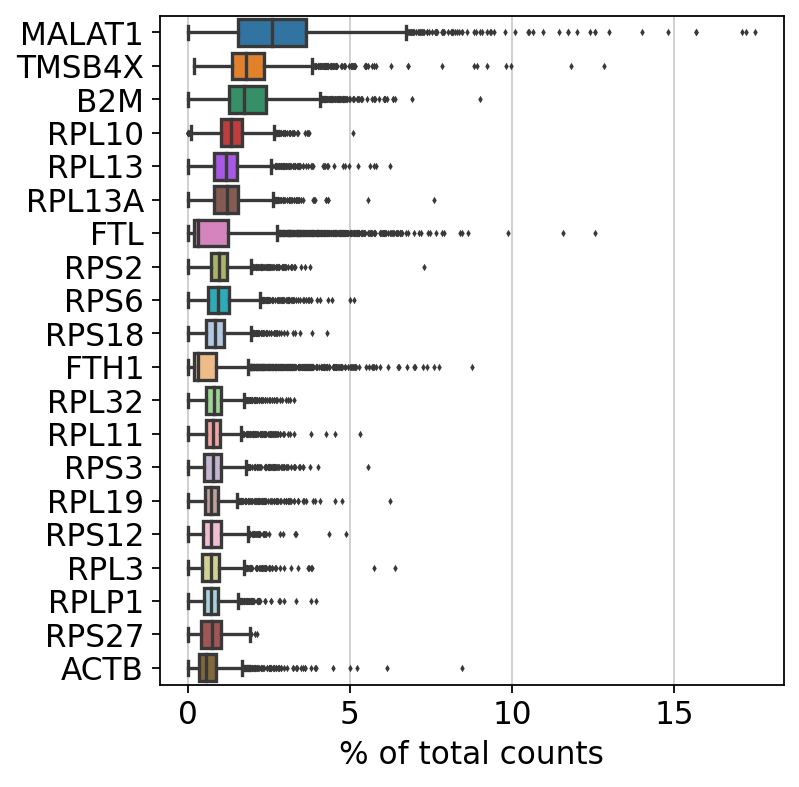

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [9]:
mito_genes = adata.var_names.str.startswith('MT-')

In [10]:
print(adata.X.shape)

(2700, 32738)


In [11]:
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata.obs['percent_mito'] = adata[:,mito_genes].X.sum(axis=1).A1 / adata.obs['n_counts']

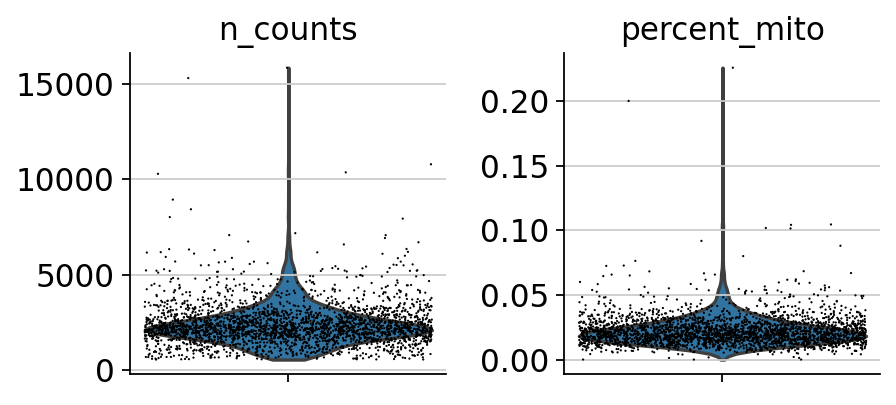

In [12]:
sc.pl.violin(adata, keys=['n_counts', 'percent_mito'], multi_panel=True, jitter=0.4)

### Basic filtering

Add `'n_genes'` key to adata's obs attribute

In [13]:
sc.pp.filter_cells(adata, min_genes=200)

In [14]:
adata.shape

(2700, 32738)

In [15]:
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [16]:
adata.shape

(2700, 13714)

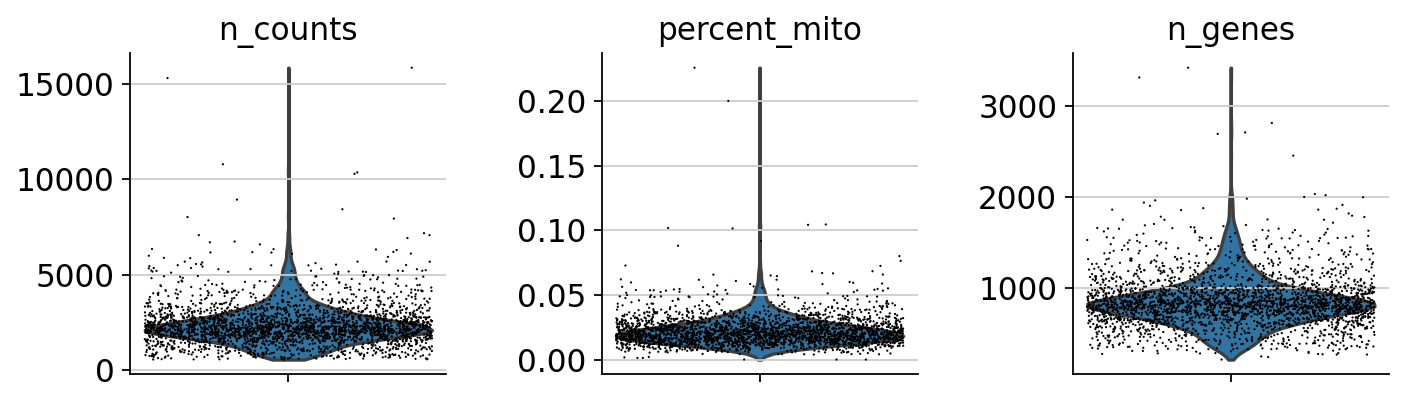

In [17]:
sc.pl.violin(adata,keys=['n_counts', 'percent_mito', 'n_genes'], multi_panel=True, jitter=0.4)

In [18]:
adata.obs

,n_counts,percent_mito,n_genes
AAACATACAACCAC-1,2421.0,0.030153,781
AAACATTGAGCTAC-1,4903.0,0.037936,1352
AAACATTGATCAGC-1,3149.0,0.008892,1131
AAACCGTGCTTCCG-1,2639.0,0.017431,960
AAACCGTGTATGCG-1,981.0,0.012232,522
...,...,...,...
TTTCGAACTCTCAT-1,3461.0,0.021092,1155
TTTCTACTGAGGCA-1,3447.0,0.009283,1227
TTTCTACTTCCTCG-1,1684.0,0.021971,622
TTTGCATGAGAGGC-1,1024.0,0.020508,454


In [19]:
adata.var

,gene_ids,n_cells
AL627309.1,ENSG00000237683,9
AP006222.2,ENSG00000228463,3
RP11-206L10.2,ENSG00000228327,5
RP11-206L10.9,ENSG00000237491,3
LINC00115,ENSG00000225880,18
...,...,...
AC145212.1,ENSG00000215750,16
AL592183.1,ENSG00000220023,323
AL354822.1,ENSG00000215615,8
PNRC2-1,ENSG00000215700,110


plot scatter plot

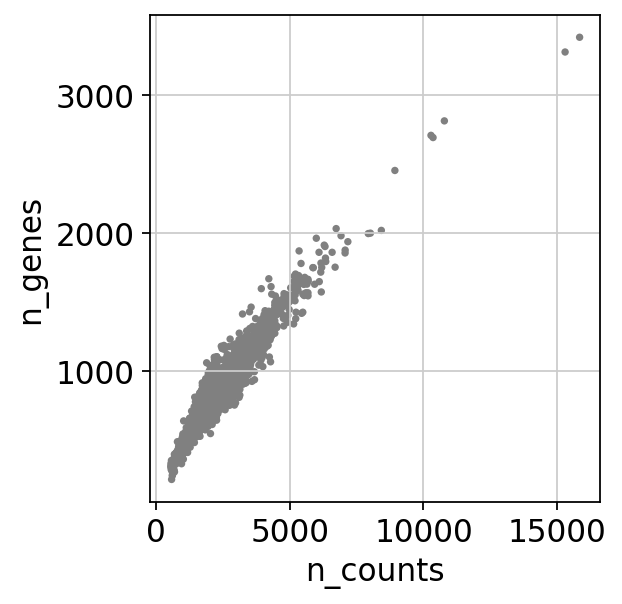

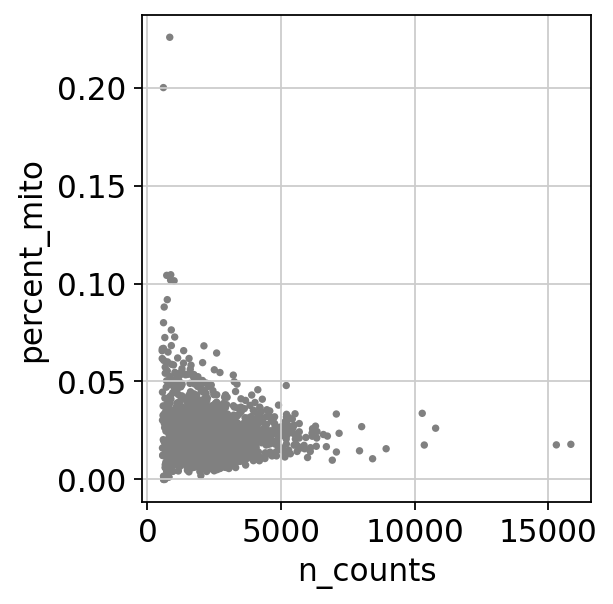

In [20]:
sc.pl.scatter(adata, x='n_counts', y='n_genes')
sc.pl.scatter(adata, x='n_counts', y='percent_mito')

We takes 2,000 genes and 10% of mitochondrie RNA as thresholds.

In [21]:
adata = adata[adata.obs['n_genes'] < 2000, :]
adata = adata[adata.obs['percent_mito'] < 0.10, :]

## Normalization

<div class="alert alert-info">
    I don't understand why the original authors have used a `target_sum` that equals 10,000 reads.
</div>

In [22]:
# sc.pp.normalize_total(adata, target_sum=1e6, inplace=True)
# sc.pp.normalize_total(adata, inplace=True)
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/julienlin/miniconda3/envs/singleCel/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


#### log(x+1) transformation

In [23]:
sc.pp.log1p(adata)

## Data correction and integration

### Regressing out technical effects

before to regress out we set `.raw` of adata to the normalized and the logarized state

In [24]:
adata.raw = adata

There is an error when I don't identify first the highly variable gene (HVG)

In [25]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [26]:
adata.var

,gene_ids,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000237683,9,False,0.013320,1.432896,-0.659169
AP006222.2,ENSG00000228463,3,False,0.004614,1.458643,-0.608669
RP11-206L10.2,ENSG00000228327,5,False,0.005133,1.382882,-0.757263
RP11-206L10.9,ENSG00000237491,3,False,0.002598,0.859277,-1.784240
LINC00115,ENSG00000225880,18,False,0.026963,1.457584,-0.610747
...,...,...,...,...,...,...
AC145212.1,ENSG00000215750,16,False,0.026967,1.784712,0.030868
AL592183.1,ENSG00000220023,323,False,0.479255,1.861235,-0.463762
AL354822.1,ENSG00000215615,8,False,0.011945,1.781954,0.025458
PNRC2-1,ENSG00000215700,110,False,0.159285,1.580025,-0.370597


In [27]:
adata = adata[:, adata.var.highly_variable]

In [28]:
adata.shape

(2685, 1859)

<div class="alert alert-info">
    I don't understand why I have to filter non-HVG before regressing out.
</div>

Regress out count depth.

In [29]:
sc.pp.regress_out(adata, ['n_counts'])

regressing out ['n_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:08)


Scale gene expression

In [30]:
sc.pp.scale(adata, max_value=10)

### Expression recovery

Fristly we don't do that.

## Feature selection, dimensionality reduction and visualization

<div class="alert alert-info">
    Normaly, I suppose that the HVG are selected here.
</div>

Doing PCA

In [31]:
sc.pp.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


Ploting pca

In [32]:
high_var = adata.var[adata.var.means > 2.5].axes[0].values
# = ['TNFRSF4', 'S100B','CPSF3L','RER1', 'SUMO3', 'ATAD3C', 'BACH1', 'LTB', 'CST3', 'S100A6']

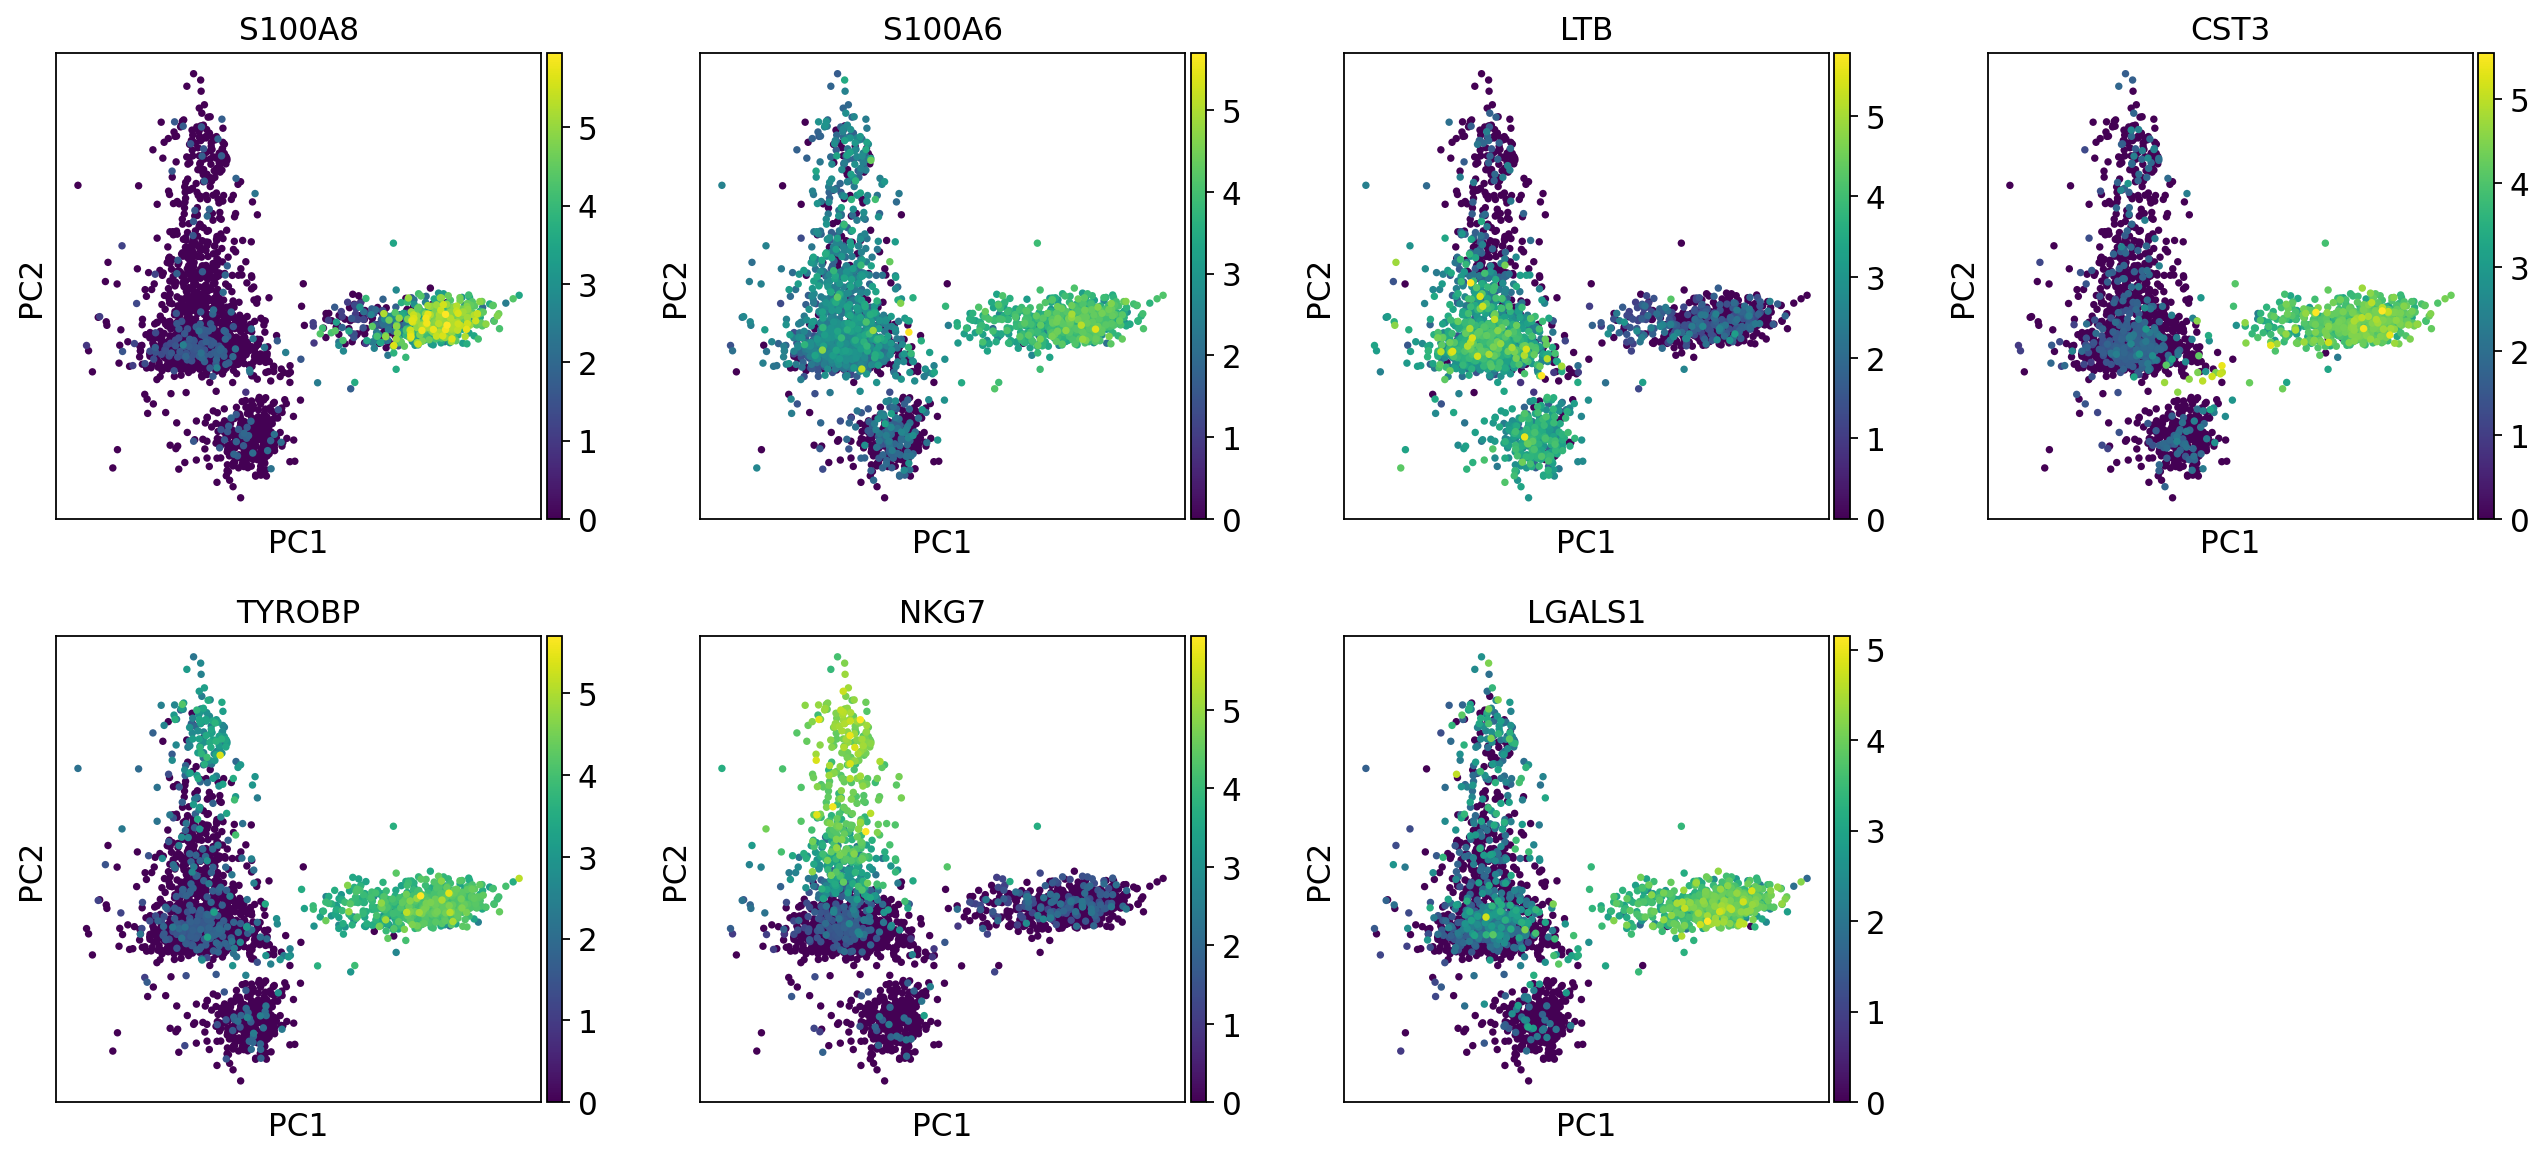

In [33]:
sc.pl.pca(adata,
         color=high_var)

Ploting genes with means > 2.5

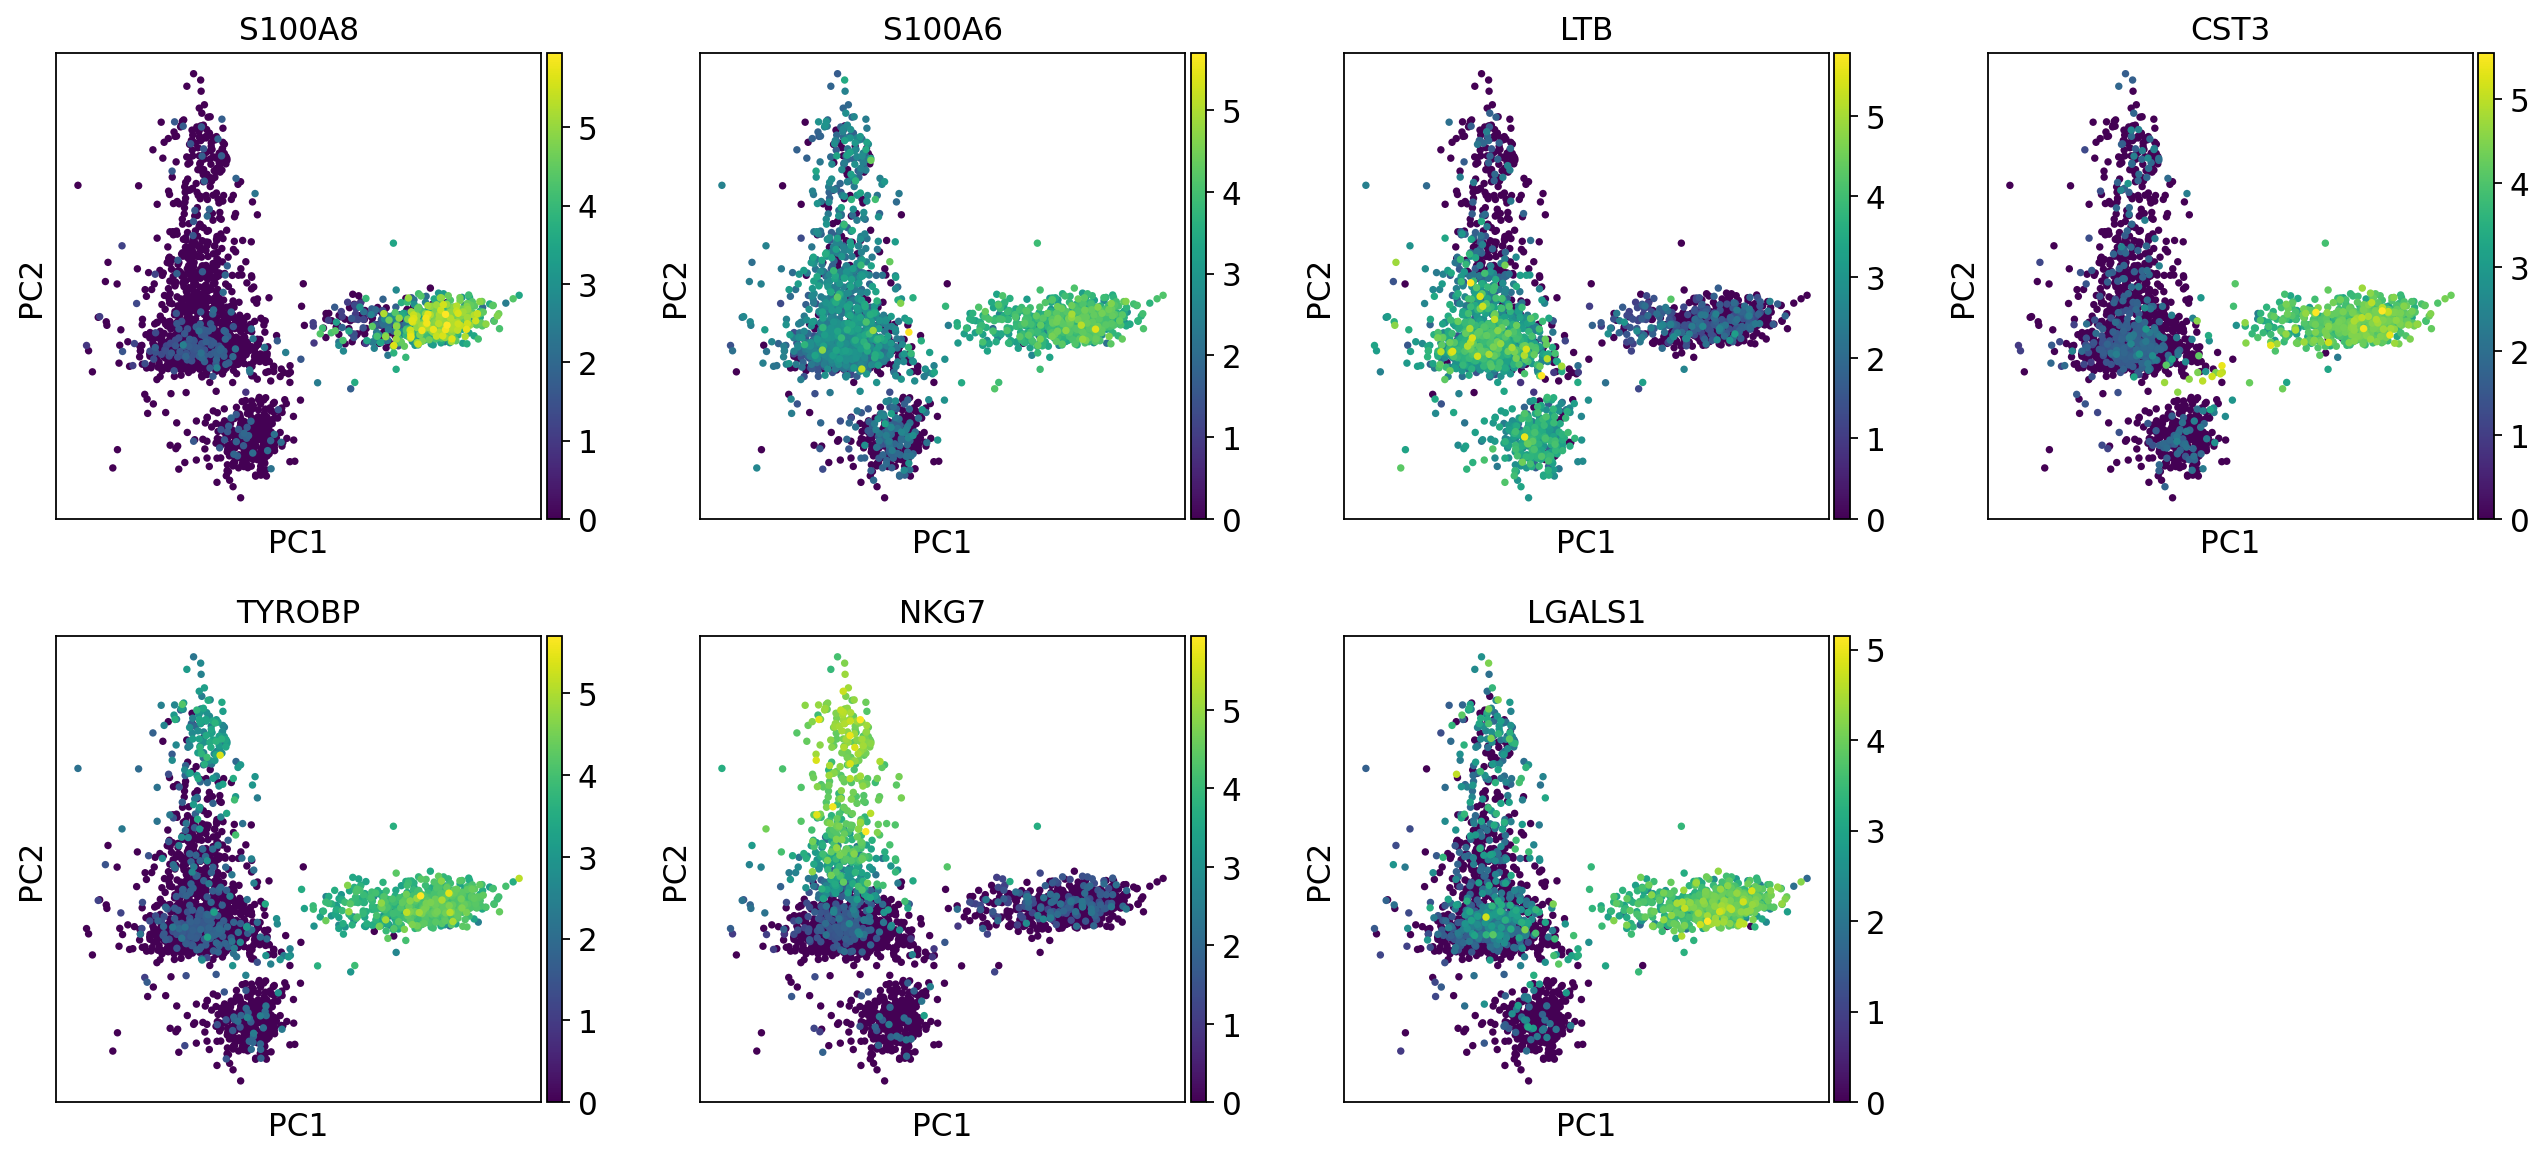

In [34]:
sc.pl.pca(adata, color=['S100A8', 'S100A6', 'LTB', 'CST3', 'TYROBP', 'NKG7','LGALS1'])

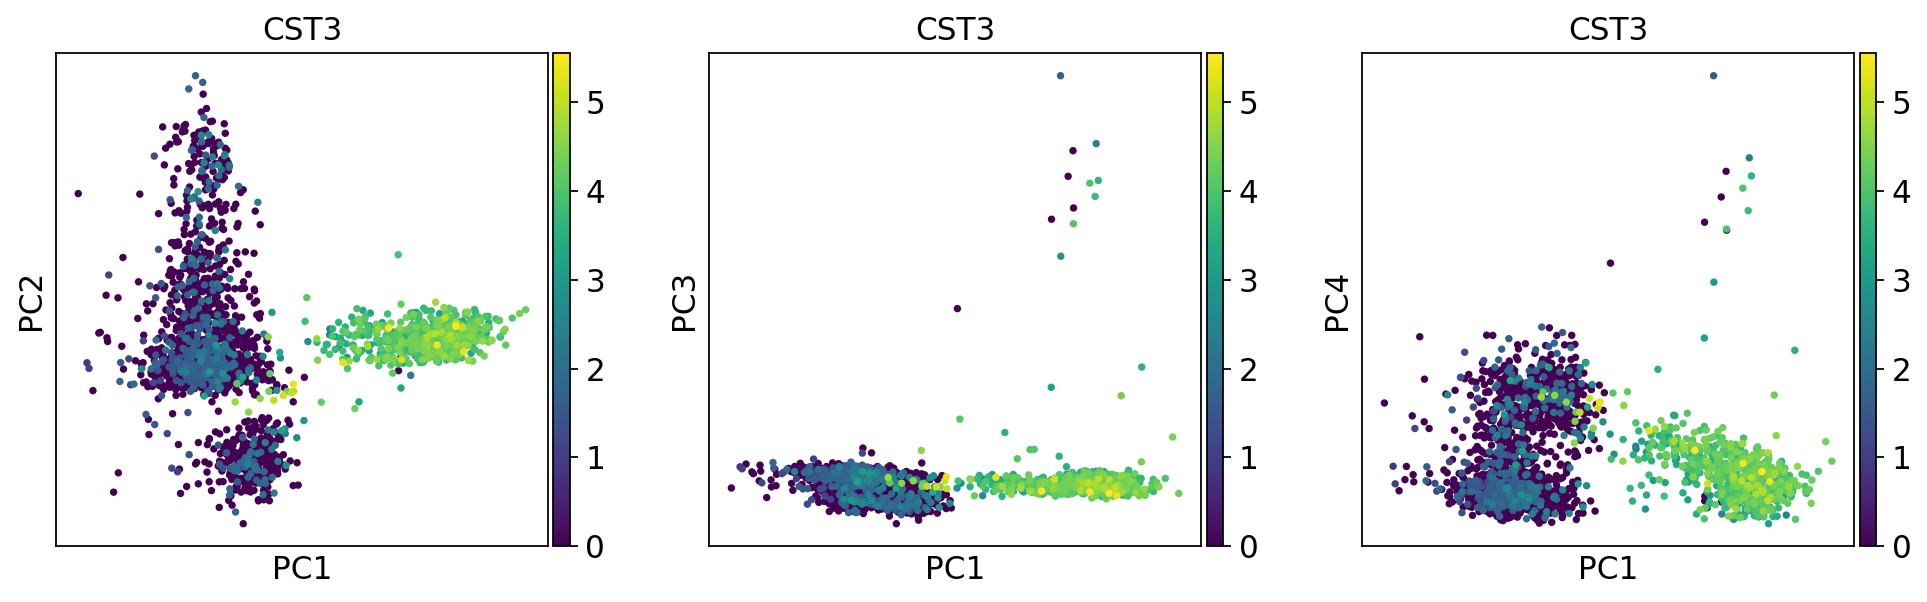

In [35]:
sc.pl.pca(adata, color='CST3', components=['1,2', '1,3', '1, 4'])

Plot the variance_ratio of each PC

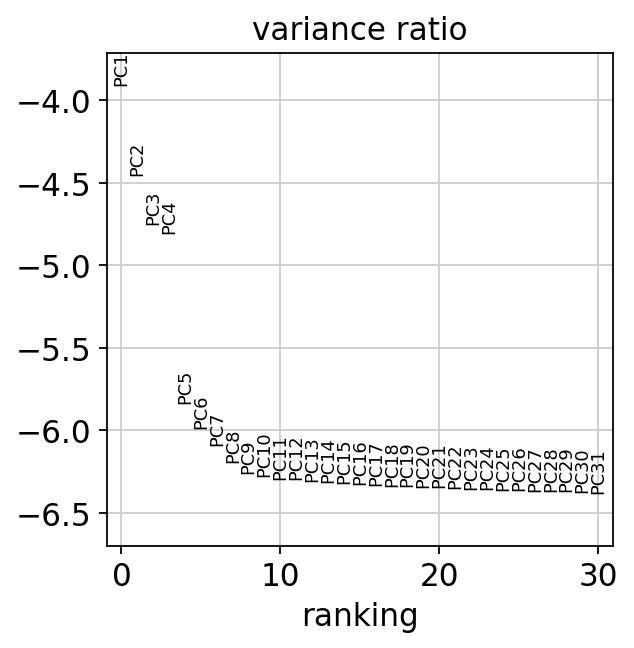

In [36]:
sc.pl.pca_variance_ratio(adata, log=True)

Author said that a rough estimation of the number of PCs to consider is fine. In this case the number of PCs is 6 of 7. To justify this choice after PC7 contributions are almost identical, and a good threshold is -6.

## Visualization using UMAP

Must run `sc.pp.neighbors` first

In [37]:
sc.pp.neighbors(adata, n_pcs=7)

computing neighbors
    using 'X_pca' with n_pcs = 7
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [38]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


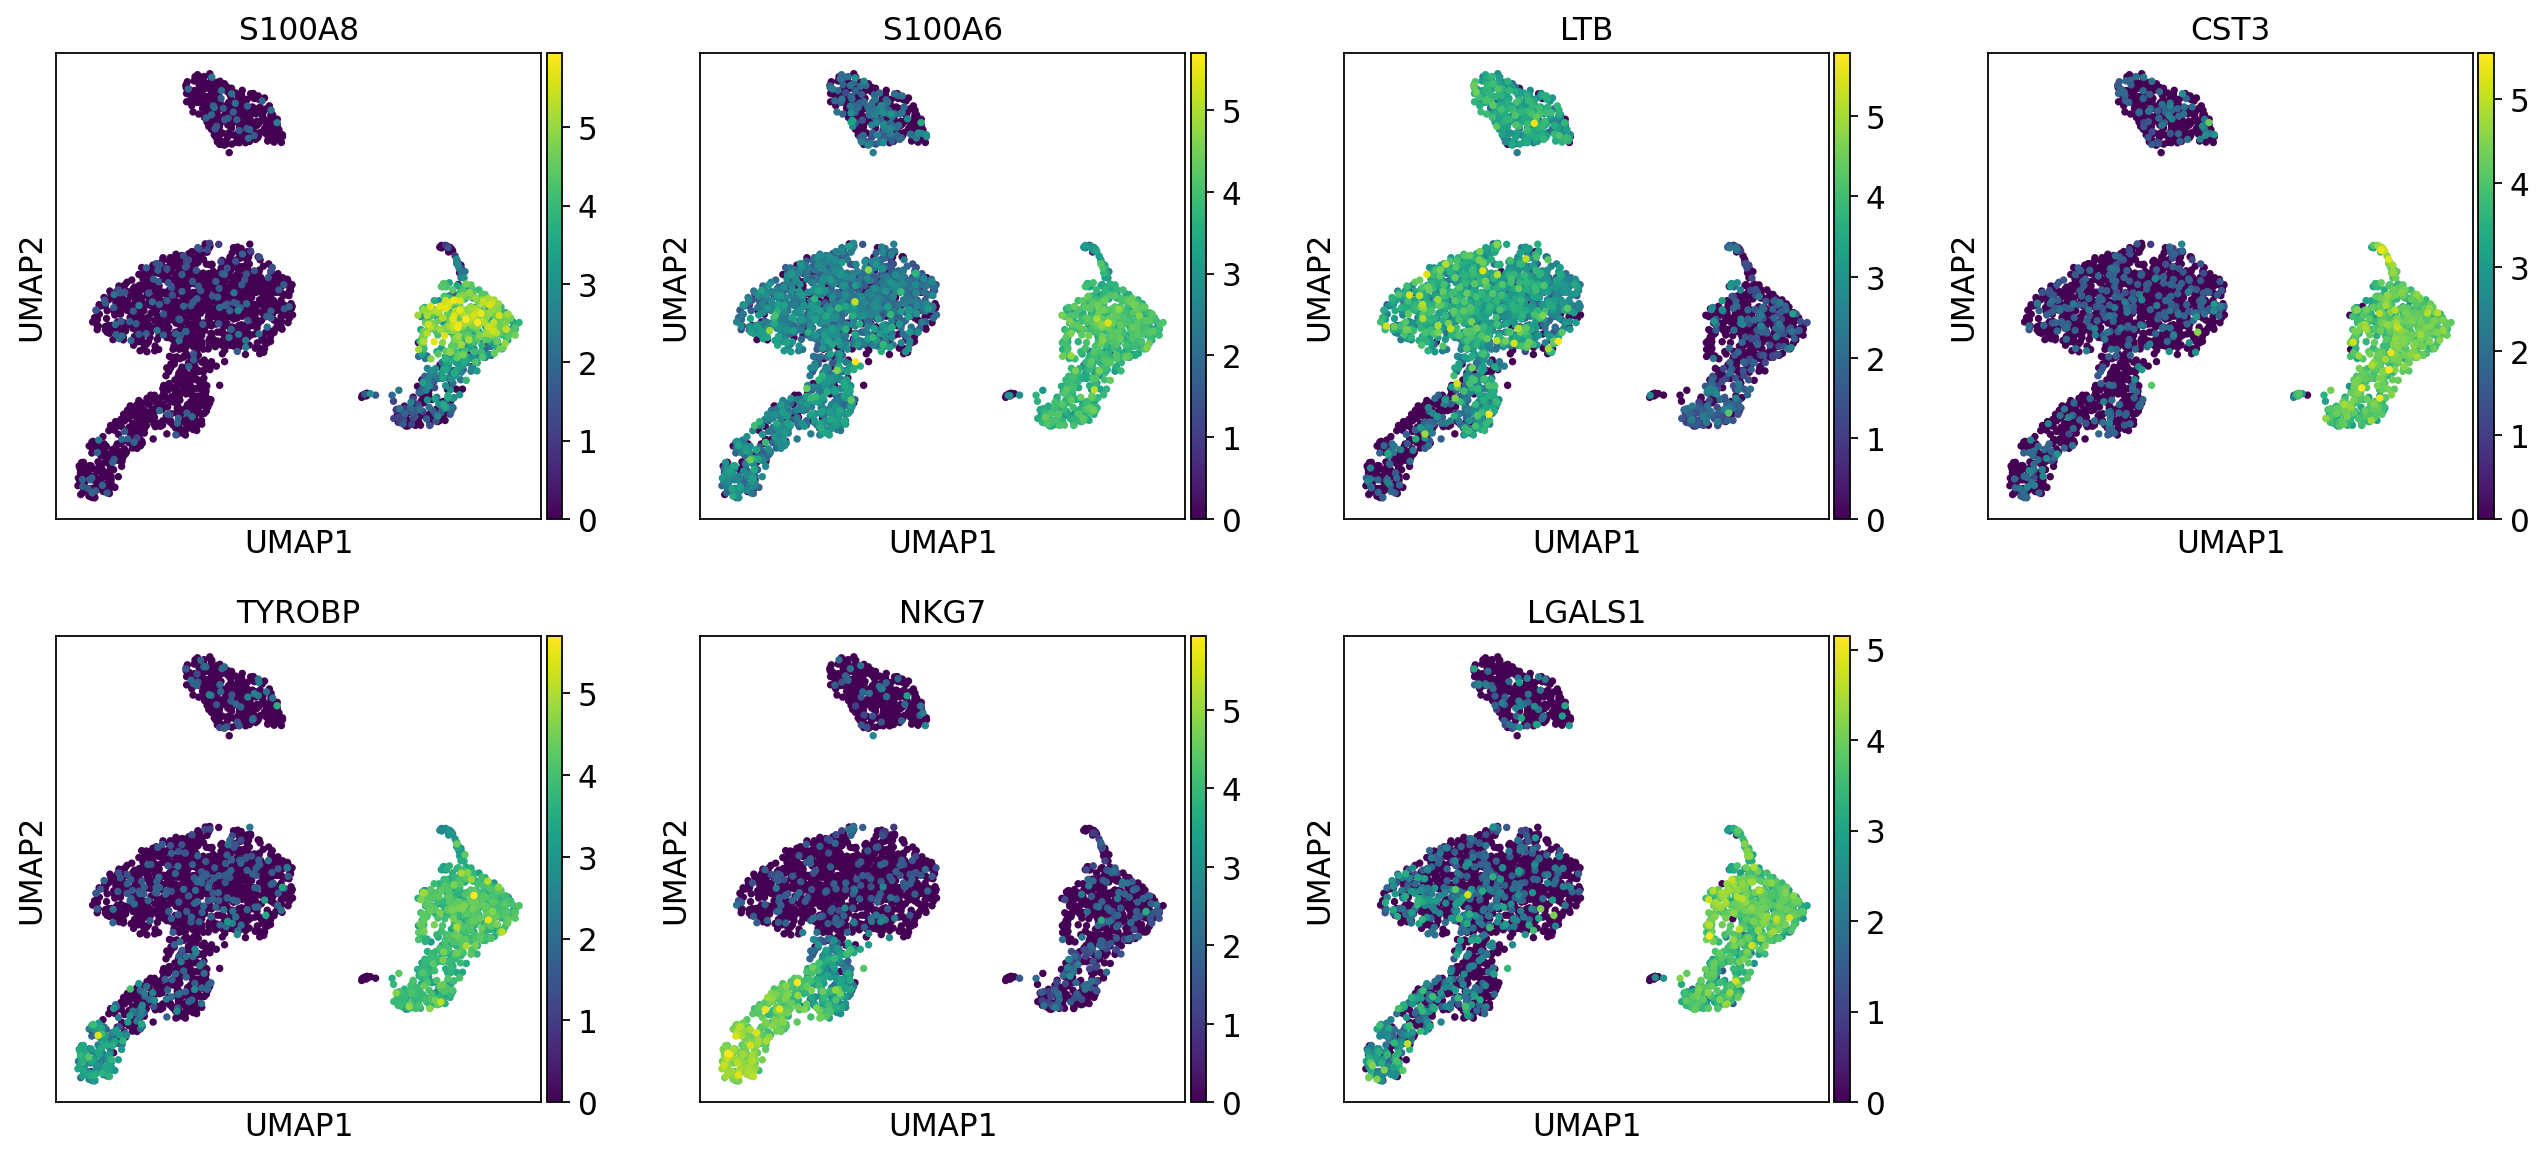

In [39]:
sc.pl.umap(adata,color=high_var)

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color=high_var)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP


We can see that shapes are not the same when we consider the 7 first PC or all the PCs. But clusters seem to be very similar for gene expressions.

## Clustering

Using leiden algorithm

In [ ]:
 sc.tl.leiden(adata)

In [ ]:
sc.pl.umap(adata, color='leiden')

<div class="alert alert-info">
    It is strange that I just have 7 clusters whereas the author have 8 clusters
</div>

Using PAGA 

In [ ]:
#sc.tl.paga(adata)
#sc.pl.paga(adata)  # remove `plot=False` if you want to see the coarse-grained graph
#sc.tl.umap(adata, init_pos='paga')

In [ ]:
#sc.pl.umap(adata,color=high_var)

## Cluster annotation using marker gene

every functions use `.raw` attribute.

In [ ]:
help(sc.tl.rank_genes_groups)

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
t_test_ranking = adata.uns['rank_genes_groups']

In [ ]:
t_test_ranking['names'][0]

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
wilcoxon_ranking = adata.uns['rank_genes_groups']

In [ ]:
adata.write(results_file)

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
logreg_ranking = adata.uns['rank_genes_groups']

In [ ]:
print(t_test_ranking['names'][0])
print(wilcoxon_ranking['names'][0])
print(logreg_ranking['names'][0])

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

<div class="alert alert-info">
    I don't understand how the author have made the tabular above. I looked myself in the results of the three methods, they gave the results above the tabular, I didn't find IL7R at the top ranking position for each methods.
</div>

Reloading adata from wilcoxon method.

In [ ]:
adata = sc.read(results_file)

Show the top 10 genes for each cluster.

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

<div class="alert alert-info">
    Even in the top 10 of the wilcoxon result IL7R isn't in it.
</div>

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [ ]:
adata.write(results_file)

<div class="alert alert-info">
    I haven't found tools to do cluster annotation. And doing it by hand seems to hard for me. So I terminated the tuto here.
</div>